In [188]:
import pandas as pd

import sys
print(sys.version)
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../../')


from drive.model_training.data_utils.extractors import * 
from drive.model_training.data_utils.animate_time_constant import * 
from first_order_model import *

from drive.util.model_func import *
from drive.util.transform_algebra import *



import matplotlib.animation as animation
from matplotlib.backend_bases import KeyEvent

import tqdm
import pickle

from matplotlib.backends.backend_pdf import PdfPages

color_dict = {"asphalt":"lightgrey", "ice":"aliceblue","gravel":"papayawhip","grass":"honeydew"}

3.10.12 (main, Jul 19 2024, 11:05:56) [GCC 11.4.0]


['cmd_body_x_lwmean' 'cmd_body_yaw_lwmean' 'cmd_left_wheels'
 'cmd_right_wheels' 'diff_body_wheel_time_constants'
 'diff_body_wheel_time_delay'
 'diff_body_wheel_time_for_63_percent_ss_value'
 'diff_body_wheel_time_for_86_percent_ss_value'
 'diff_body_wheel_time_for_95_percent_ss_value' 'icp_vel_x_smoothed'
 'icp_vel_yaw_smoothed' 'id' 'left_wheel_vel_gains'
 'left_wheel_vel_operation_points' 'left_wheel_vel_predictions'
 'left_wheel_vel_steps' 'left_wheel_vel_time_constants'
 'left_wheel_vel_time_delay'
 'left_wheel_vel_time_delay_problematic_computation'
 'left_wheel_vel_time_for_63_percent_ss_value'
 'left_wheel_vel_time_for_86_percent_ss_value'
 'left_wheel_vel_time_for_95_percent_ss_value' 'max_ang_speed_sampled'
 'max_linear_speed_sampled' 'odom_speed_left_wheels'
 'odom_speed_right_wheels' 'right_wheel_vel_gains'
 'right_wheel_vel_operation_points' 'right_wheel_vel_predictions'
 'right_wheel_vel_steps' 'right_wheel_vel_time_constants'
 'right_wheel_vel_time_delay'
 'right_wheel_

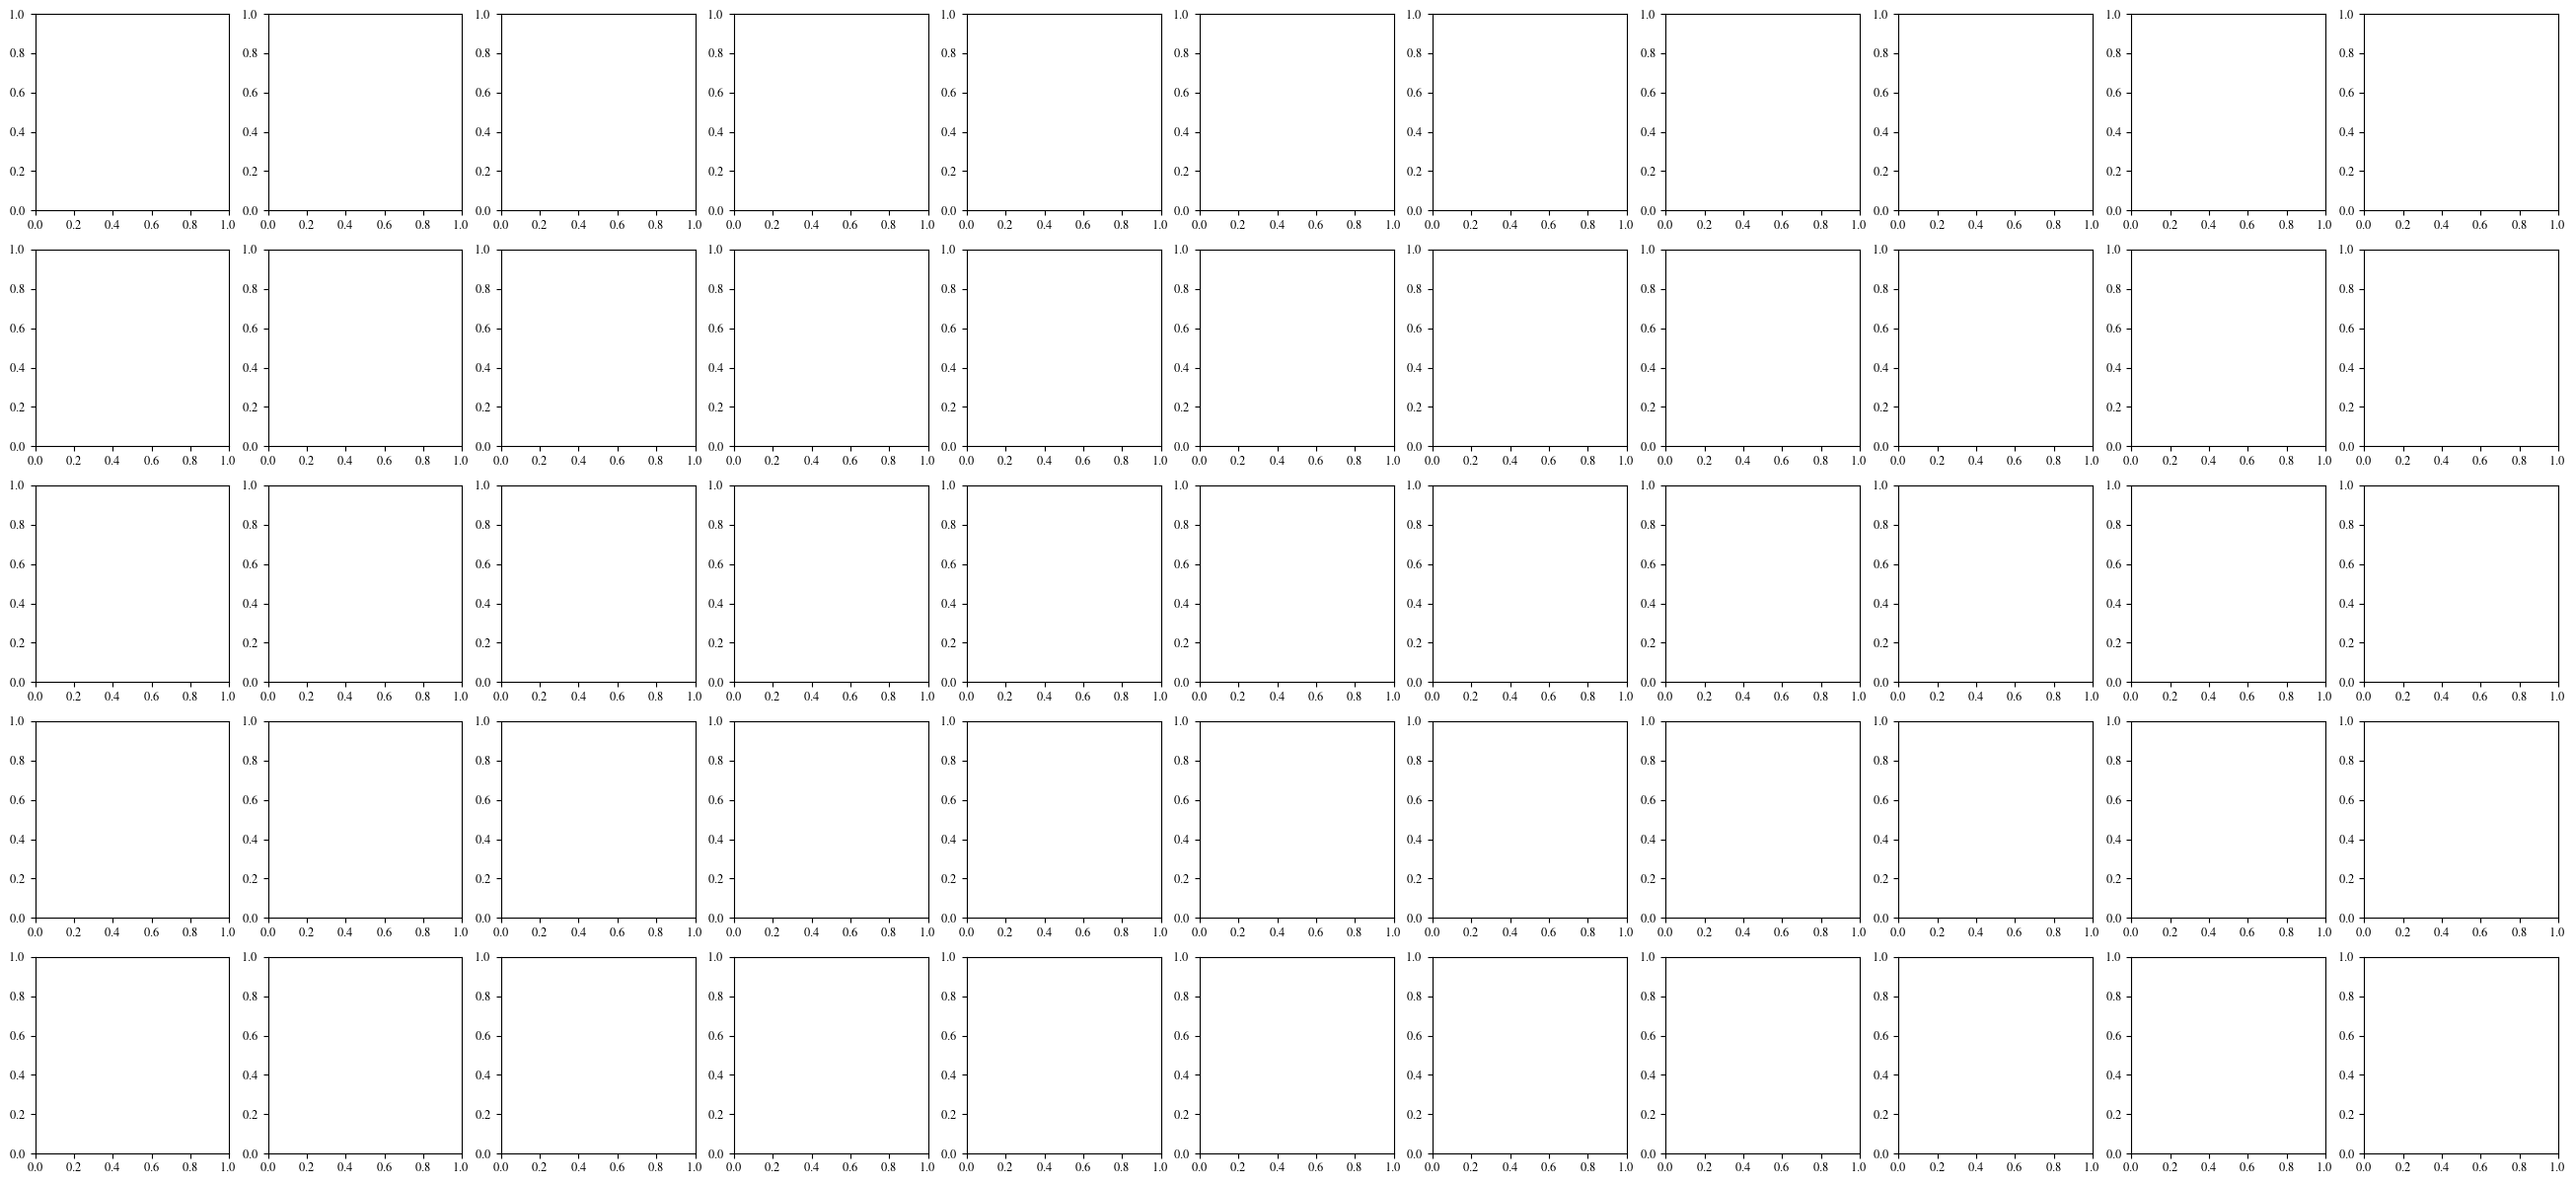

In [208]:


steady_state_path = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/all_terrain_steady_state_dataset.pkl"
df_diamond = pd.read_pickle(steady_state_path)

print_column_unique_column(df_diamond)


def graph_boxplot_by_terrain(ax,df_diamond,col_interest,label_y,color_dict):

    list_terrain = sorted((df_diamond["terrain"].unique())) # alphabetical
    size = len(list_terrain)
    #box_plot(df_diamond,axs[0,0],"allo")
    median_by_terrain = df_diamond.groupby('terrain')[col_interest].median().reset_index()
    median_by_terrain_sorted  = median_by_terrain.sort_values(by=col_interest, ascending=False).reset_index().terrain
    
    

    list_position = [i for i in range(size)]
    ax.axhline(2,min(list_position),max(list_position),color="red")
    list_boxplot = []
    for i in range(size):
        terrain = median_by_terrain_sorted[i]
        df = df_diamond.loc[df_diamond["terrain"]==terrain]
        #print(col_interest)
        box = ax.boxplot(df[col_interest].values,positions = [i],
                            boxprops=dict(color='black'),  # Box outline color
                            medianprops=dict(color='black'),  # Median line color
                            whiskerprops=dict(color='black'),  # Whiskers color
                            capprops=dict(color='black'),
                            patch_artist=True,showfliers=False)  # Caps color
                            
        list_boxplot.append(box)
        box["boxes"][0].set_facecolor(color_dict[terrain])
    ax.set_title(f"{col_interest}")
    ax.set_xticks(ticks = list_position, labels= median_by_terrain_sorted)
    ax.set_ylabel(label_y)


def boxplot_time_constant_all_speed_one_param(df,color_dict,time_constant_suffix ="time_constants",filter_out=" ",path_to_res=""):

    ####
    list_column = list(df.columns)
    col_to_keep = []
    for col in list_column:
        #print(col)
        if (time_constant_suffix in col) and (filter_out not in col):
            col_to_keep.append(col)
    ####
    
    fig, axs = plt.subplots(len(col_to_keep),1)
    fig.set_figheight(2.5 * len(col_to_keep))
    fig.set_figheight(2.5 * len(col_to_keep))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    label_y = "Time [s]"
    col_interest = "step_frame_vx_time_constants"

    for col_interest,ax in zip(col_to_keep,np.ravel(axs)):
       
        graph_boxplot_by_terrain(ax,df,col_interest,label_y,color_dict)
    if path_to_res != "":
        fig.savefig(path_to_res/(time_constant_suffix+".pdf"))
    return axs


def produce_all_time_constant_boxplot(df_diamond,color_dict,path_to_results):

    if isinstance(path_to_results,str):
        path_to_results = pathlib.Path(path_to_results)

    path_to_time_cst_analysis = path_to_results/"first_order_analysis"
    if path_to_time_cst_analysis.is_dir()==False:
        path_to_time_cst_analysis.mkdir()

    

    list_col_interest = ['gains','time_constants','time_delay',"_for_63_percent_ss_value",
                        "_time_for_86_percent_ss_value","_time_for_95_percent_ss_value",
                        "diff_body_wheel_time_constants","diff_body_wheel_time_delay",
                        "diff_body_wheel_time_for_86_percent_ss_value",
                        "diff_body_wheel_time_for_95_percent_ss_value",
                        'diff_body_wheel_time_for_63_percent_ss_value']
    list_col_to_filter_out = [" ","to_show","problematic", " "," "," ", " "," ", " ", " ", " "]

    print(len(list_col_interest))
    print(len(list_col_to_filter_out))
    list_axs = []
    for time_constant_suffix, filter_out in zip(list_col_interest,list_col_to_filter_out):
        list_axs.append(boxplot_time_constant_all_speed_one_param(df_diamond,color_dict,time_constant_suffix =time_constant_suffix,filter_out=filter_out,path_to_res=path_to_time_cst_analysis))
    #     'right_wheel_vel_operation_points', 'right_wheel_vel_steps',
    plt.close("all")
    ncol = len(list_axs)
    nrow = list_axs[0].shape[0]
    fig, axs = plt.subplots(nrow,ncol)

    scale_factor = 3
    fig.set_figheight(nrow*scale_factor)
    fig.set_figwidth(ncol*scale_factor)

    #for i in range(ncol):
    #    print(nrow)
    #    axs[:,i] = list_axs[i]

    #fig.savefig("/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/analysis/test_time_constant")

#boxplot_time_constant_all_speed_one_param(df_diamond,color_dict,time_constant_suffix ="time_constants",filter_out="to_show")

df_sampling_speed = df_diamond.loc[df_diamond["max_linear_speed_sampled"]==5.0]

df_diamond_roboticist_dom = df_sampling_speed.loc[df_sampling_speed["roboticist"]=="dominicbaril"]

df_diamond_roboticist_dom = df_sampling_speed.loc[df_sampling_speed["roboticist"]=="nicolassamson"]
produce_all_time_constant_boxplot(df_sampling_speed,color_dict,path_to_results="/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe")

In [ ]:
for ordered_i in median_order:
    print(median_by_terrain_sorted.loc[ordered_i])
    terrain = list_terrain[ordered_i]
    df = df_diamond.loc[df_diamond["terrain"]==terrain]
    box = ax.boxplot(df[col_interest].values,positions = [list_position[ordered_i]],
                        boxprops=dict(color='black'),  # Box outline color
                          medianprops=dict(color='black'),  # Median line color
                          whiskerprops=dict(color='black'),  # Whiskers color
                          capprops=dict(color='black'),
                          patch_artist=True,showfliers=False)  # Caps color
                        
    list_boxplot.append(box)
    box["boxes"][0].set_facecolor(color_dict[terrain])


/tmp/ipykernel_5393/2746649452.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_diamond[sorting_name] = df_diamond["terrain"].replace(median_by_terrain)


TypeError: 'Axes' object is not subscriptable

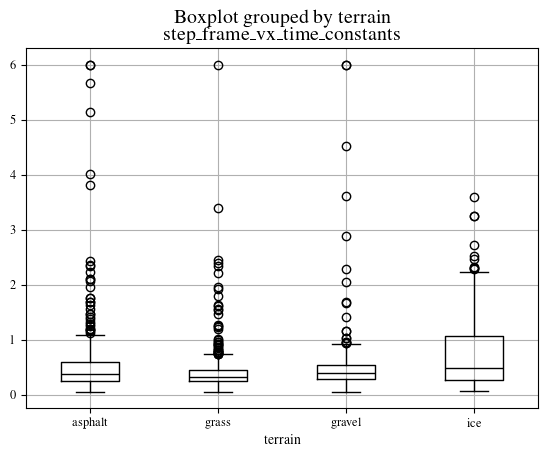

In [130]:
# Sorted the values 
# Compute the median values for each terrain and sort them
median_values = df_diamond.groupby('terrain')[col_interest].median().sort_values()
sorted_terrains = median_values.index
df_diamond['terrain_argsort'] = df_diamond['terrain'].argsort()

# Create filter  
median_by_terrain = df_diamond.groupby('terrain')[col_interest].median()

sorting_name = "median_by"+col_interest
df_diamond[sorting_name] = df_diamond["terrain"].replace(median_by_terrain)
df_diamond.sort_values(sorting_name,inplace=True)

# Convert the 'terrain' column to a categorical type with the specified order
#df_diamond['terrain'] = pd.Categorical(df_diamond['terrain'], categories=median_by_terrain, ordered=True)

box = df_diamond.boxplot(column=col_interest, by='terrain', 
                          boxprops=dict(color='black'),  # Box outline color
                          medianprops=dict(color='black'),  # Median line color
                          whiskerprops=dict(color='black'),  # Whiskers color
                          capprops=dict(color='black'))  # Caps color

# Iterate through each box and set the face color
for i, terrain in enumerate(df_diamond['terrain'].unique()):
    box['boxes'][i].set_facecolor(color_dict[terrain])


$$
Time2SteadyState= Tss
\newline
diff_{Tss} =max( Vx_{Tss},Vyaw_{Tss}) -  max( \omega L_{Tss},\omega R_{Tss})
$$

In [34]:
path_to_dataset = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/data/warthog/wheels/asphalt/warthog_wheels_asphalt_2024_9_20_8h21s48/model_training_datasets/slip_dataset_all.pkl"
df = pd.read_pickle(path_to_dataset)
imu_acceleration_x = column_type_extractor(df,"imu_acceleration_x",verbose=False,steady_state=False)
imu_acceleration_x_transient = column_type_extractor(df,"imu_acceleration_x",verbose=False,steady_state=True)
steady_state_path = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/data/warthog/wheels/asphalt/warthog_wheels_asphalt_2024_9_20_8h21s48/model_training_datasets/steady_state_results.pkl"
df_diamond = pd.read_pickle(steady_state_path)
print_column_unique_column(df_diamond)






['cmd_body_x_lwmean' 'cmd_body_yaw_lwmean' 'cmd_left_wheels'
 'cmd_right_wheels' 'icp_vel_x_smoothed' 'icp_vel_yaw_smoothed'
 'left_wheel_vel_gains' 'left_wheel_vel_operation_points'
 'left_wheel_vel_predictions' 'left_wheel_vel_steps'
 'left_wheel_vel_time_constants' 'left_wheel_vel_time_constants_to_show'
 'left_wheel_vel_time_delay'
 'left_wheel_vel_time_delay_problematic_computation'
 'odom_speed_left_wheels' 'odom_speed_right_wheels'
 'right_wheel_vel_gains' 'right_wheel_vel_operation_points'
 'right_wheel_vel_predictions' 'right_wheel_vel_steps'
 'right_wheel_vel_time_constants' 'right_wheel_vel_time_constants_to_show'
 'right_wheel_vel_time_delay'
 'right_wheel_vel_time_delay_problematic_computation' 'robot'
 'slip_body_x_ss' 'slip_body_y_ss' 'slip_body_yaw_ss' 'slip_wheel_left_ss'
 'slip_wheel_right_ss' 'step_frame_vx_gains'
 'step_frame_vx_operation_points' 'step_frame_vx_predictions'
 'step_frame_vx_steps' 'step_frame_vx_time_constants'
 'step_frame_vx_time_constants_to_show'

array(['cmd_body_x_lwmean', 'cmd_body_yaw_lwmean', 'cmd_left_wheels',
       'cmd_right_wheels', 'icp_vel_x_smoothed', 'icp_vel_yaw_smoothed',
       'left_wheel_vel_gains', 'left_wheel_vel_operation_points',
       'left_wheel_vel_predictions', 'left_wheel_vel_steps',
       'left_wheel_vel_time_constants',
       'left_wheel_vel_time_constants_to_show',
       'left_wheel_vel_time_delay',
       'left_wheel_vel_time_delay_problematic_computation',
       'odom_speed_left_wheels', 'odom_speed_right_wheels',
       'right_wheel_vel_gains', 'right_wheel_vel_operation_points',
       'right_wheel_vel_predictions', 'right_wheel_vel_steps',
       'right_wheel_vel_time_constants',
       'right_wheel_vel_time_constants_to_show',
       'right_wheel_vel_time_delay',
       'right_wheel_vel_time_delay_problematic_computation', 'robot',
       'slip_body_x_ss', 'slip_body_y_ss', 'slip_body_yaw_ss',
       'slip_wheel_left_ss', 'slip_wheel_right_ss', 'step_frame_vx_gains',
       'step_frame_v

In [27]:
list_names = ['cmd_body_x_lwmean', 'cmd_body_yaw_lwmean', 'cmd_left_wheels',
       'cmd_right_wheels', 'icp_vel_x_smoothed', 'icp_vel_yaw_smoothed',
       'left_wheel_vel_gains', 'left_wheel_vel_operation_points',
       'left_wheel_vel_predictions', 'left_wheel_vel_steps',
       'left_wheel_vel_time_constants',
       'left_wheel_vel_time_constants_to_show',
       'left_wheel_vel_time_delay',
       'left_wheel_vel_time_delay_problematic_computation',
       'odom_speed_left_wheels', 'odom_speed_right_wheels',
       'right_wheel_vel_gains', 'right_wheel_vel_operation_points',
       'right_wheel_vel_predictions', 'right_wheel_vel_steps',
       'right_wheel_vel_time_constants',
       'right_wheel_vel_time_constants_to_show',
       'right_wheel_vel_time_delay',
       'right_wheel_vel_time_delay_problematic_computation', 'robot',
       'slip_body_x_ss', 'slip_body_y_ss', 'slip_body_yaw_ss',
       'slip_wheel_left_ss', 'slip_wheel_right_ss', 'step_frame_vx_gains',
       'step_frame_vx_operation_points', 'step_frame_vx_predictions',
       'step_frame_vx_steps', 'step_frame_vx_time_constants',
       'step_frame_vx_time_constants_to_show', 'step_frame_vx_time_delay',
       'step_frame_vx_time_delay_problematic_computation',
       'step_frame_vy_gains', 'step_frame_vy_operation_points',
       'step_frame_vy_predictions', 'step_frame_vy_steps',
       'step_frame_vy_time_constants',
       'step_frame_vy_time_constants_to_show', 'step_frame_vy_time_delay',
       'step_frame_vy_time_delay_problematic_computation',
       'step_frame_vyaw_gains', 'step_frame_vyaw_operation_points',
       'step_frame_vyaw_predictions', 'step_frame_vyaw_steps',
       'step_frame_vyaw_time_constants',
       'step_frame_vyaw_time_constants_to_show',
       'step_frame_vyaw_time_delay',
       'step_frame_vyaw_time_delay_problematic_computation', 'terrain',
       'traction']

print("[")
for names in list_names:
    
    if "_steps" in names and "to_show" not in names :
        print(f"'{names}',")


[
'left_wheel_vel_steps',
'right_wheel_vel_steps',
'step_frame_vx_steps',
'step_frame_vy_steps',
'step_frame_vyaw_steps',


In [28]:


def plot_histogramme(ax,df,column_of_interest,transient_only_flag=True,nb_bins=30,range=(0,0)):


    if transient_only_flag:
        imu_acceleration_x = column_type_extractor(df,column_of_interest,verbose=False,steady_state=False)
        labels_y = column_of_interest+"\n transient_state"
    
    else:
        imu_acceleration_x= column_type_extractor(df,column_of_interest,verbose=False,steady_state=True)
        labels_y = column_of_interest

    
    if range == (0,0):
            ax.hist(imu_acceleration_x,bins=nb_bins)
    else:
            ax.hist(imu_acceleration_x,bins=nb_bins,range=range)


    
    ax.set_xlabel(labels_y)
    
def global_y_axis(axs):
    
    flatten_axs = np.ravel(axs)
    
    min = 0 
    max = 0
    for ax in flatten_axs:
        if ax.get_ylim()[1]> max:
            max =  ax.get_ylim()[1]

    for ax in flatten_axs:
        ax.set_ylim(min,max)


def plot_all(df,list_of_column_of_interest,nb_bins=25,range=(0,0)):

    fig, axs = plt.subplots(1,3)
    fig.set_figwidth(3*len(list_of_column_of_interest))
    
    for ax,column_of_interest in zip(axs,list_of_column_of_interest):

        plot_histogramme(ax,df,column_of_interest,nb_bins=nb_bins,range=range)


    global_y_axis(axs)

    return fig

def plot_diamond_hist(df, list_of_column_of_interest,nb_bins=25, range=(0,0)): 
    test = ["icp_vel_x_gains","icp_vel_y_gains","icp_vel_yaw_gains","left_wheel_vel_gains","right_wheel_vel_gains"]
    fig, axs = plt.subplots(1,len(list_of_column_of_interest))
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):

        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)



        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)

    return fig

In [29]:
# Descriptions 

def plot_acceleration_histogramme(df,nb_bins=30,range=(0,0)):
    

    list_of_column_of_interest = ["imu_acceleration_x","imu_acceleration_y","imu_yaw"]
    df = df
    
    fig, axs = plt.subplots(1,3)
    fig.set_figwidth(3*len(list_of_column_of_interest))
    

    plot_all(axs,df,list_of_column_of_interest,nb_bins=30,range=range)


def plot_slip_histogramme(df,nb_bins=30,range=(0,0)):
    fig, axs = plt.subplots(1,3)

    list_of_column_of_interest = ["body_vel_disturption_x","body_vel_disturption_y","body_vel_disturption_yaw"]
    df = df
    fig.set_figwidth(3*len(axs))

    plot_all(axs,df,list_of_column_of_interest,nb_bins=nb_bins,range=range)

def plot_steps_histogramme(df,nb_bins=30,range=(0,0)):

    fig, axs = plt.subplots(1,3)

    list_of_column_of_interest = ["step_frame_vx","step_frame_vy","step_frame_vy"]
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):
        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            axs[i].set_xlabel(column_of_interest)
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)
    
        axs[i].set_xlabel(column_of_interest)
    
    global_y_axis(axs)
def plot_operation_histogramme(df,nb_bins=30,range=(0,0)):

    fig, axs = plt.subplots(1,3)

    list_of_column_of_interest = [
    'left_wheel_vel_operation_points',
    'right_wheel_vel_operation_points',
    'step_frame_vx_operation_points',
    'step_frame_vy_operation_points',
    'step_frame_vyaw_operation_points']
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):
        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            axs[i].set_xlabel(column_of_interest)
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)

        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)
def plot_time_constant(df,nb_bins=30,range=(0,0)):

    fig, axs = plt.subplots(1,5)

    list_of_column_of_interest = [
    'left_wheel_vel_time_constants',
    'right_wheel_vel_time_constants',
    'step_frame_vx_time_constants',
    'step_frame_vy_time_constants',
    'step_frame_vyaw_time_constants']
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):
        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)

        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)
        
def plot_proportionnal_slip(df,nb_bins=30,range=(0,0),name=""):
    list_of_column_of_interest = ["left_wheel_vel_gains","right_wheel_vel_gains","step_frame_vx_gains","step_frame_vy_gains","step_frame_vyaw_gains"]
    fig, axs = plt.subplots(1,len(list_of_column_of_interest))
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):

        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)



        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)

    # Save the figure using pickle
    #with open(name, 'wb') as f:
    #    pickle.dump(fig, f)

    



def plot_all_histogramme(df, df_diamond,path_to_results):

    name = "diamond_hist.pkl"

    list_fig = []
    list_of_column_of_interest = [
    'left_wheel_vel_steps',
    'right_wheel_vel_steps',
    'step_frame_vx_steps',
    'step_frame_vy_steps',
    'step_frame_vyaw_steps']
    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=20,range= (-10,10)))

    list_of_column_of_interest = [
    'left_wheel_vel_operation_points',
    'right_wheel_vel_operation_points',
    'step_frame_vx_operation_points',
    'step_frame_vy_operation_points',
    'step_frame_vyaw_operation_points']
    
    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=30,range= (-5,5)))

    list_of_column_of_interest =[
    'left_wheel_vel_time_constants',
    'right_wheel_vel_time_constants',
    'step_frame_vx_time_constants',
    'step_frame_vy_time_constants',
    'step_frame_vyaw_time_constants']

    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=30, range=(0,6)))


    list_of_column_of_interest = ["left_wheel_vel_gains","right_wheel_vel_gains","step_frame_vx_gains","step_frame_vy_gains","step_frame_vyaw_gains"]
    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=30, range=(-5,5)))

    list_of_column_of_interest = ["imu_acceleration_x","imu_acceleration_y","imu_yaw"]
    list_fig.append(plot_all(df,list_of_column_of_interest,nb_bins=20,range=(-5,5)))

    list_of_column_of_interest = ["body_vel_disturption_x","body_vel_disturption_y","body_vel_disturption_yaw"]
    list_fig.append(plot_all(df,list_of_column_of_interest,nb_bins=30,range= (-5,5)))

    path_to_pdf = path_to_results/"histogramme_analysis.pdf"
    # Create a PDF file to save the figures
    with PdfPages(str(path_to_pdf)) as pdf:

        for figure in list_fig:
            pdf.savefig(figure)
            

    #plot_acceleration_histogramme(df)
    #plot_slip_histogramme(df,nb_bins=30,range= (-5,5))

    
    #plot_steps_histogramme(df_diamond,nb_bins=20,range= (-10,10))
    #plot_operation_histogramme(df_diamond,nb_bins=30,range= (-5,5))
    #plot_time_constant(df_diamond,nb_bins=30,range= (0,6))
    #plot_proportionnal_slip(df_diamond,nb_bins=30,range= (-5,5))



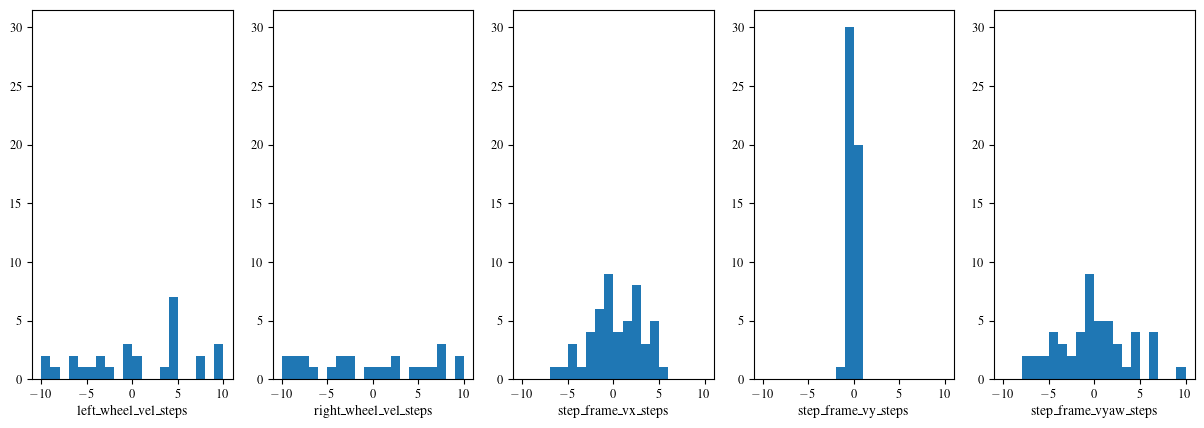

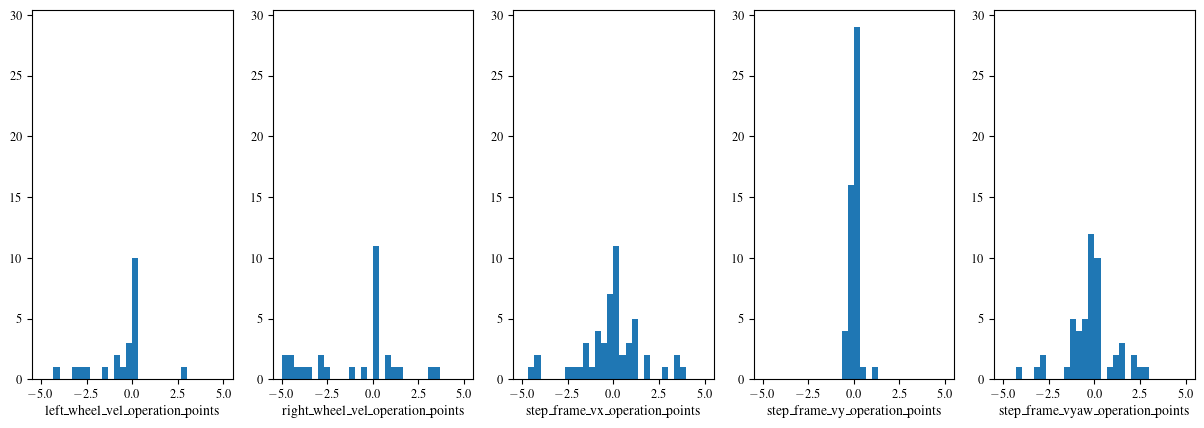

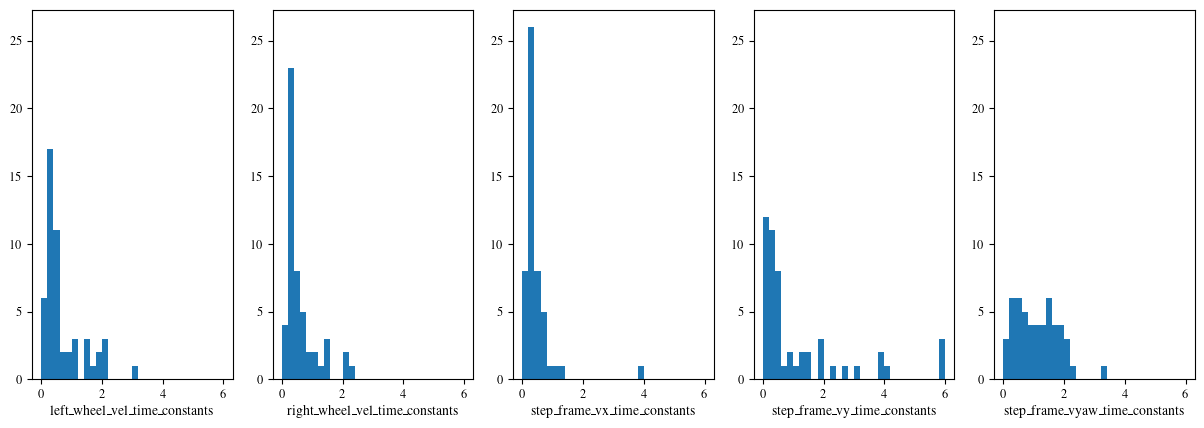

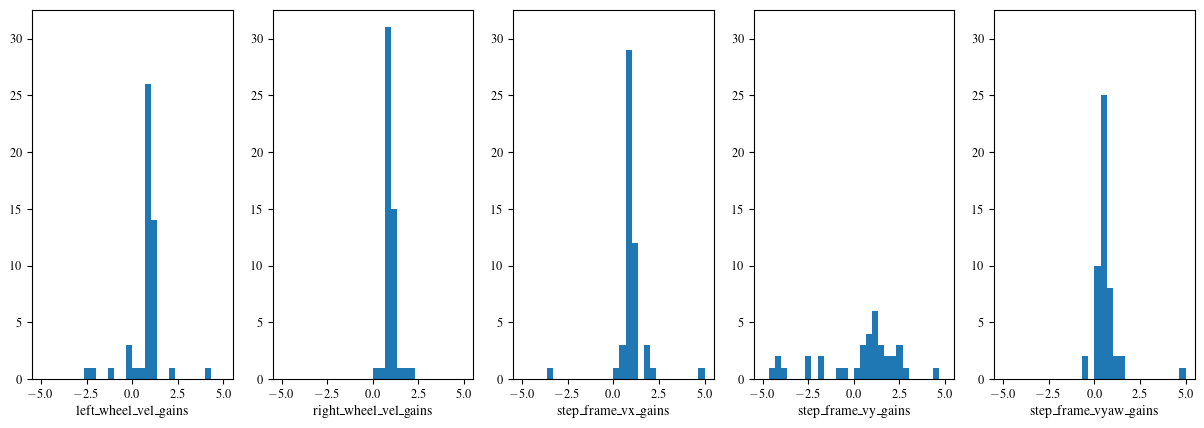

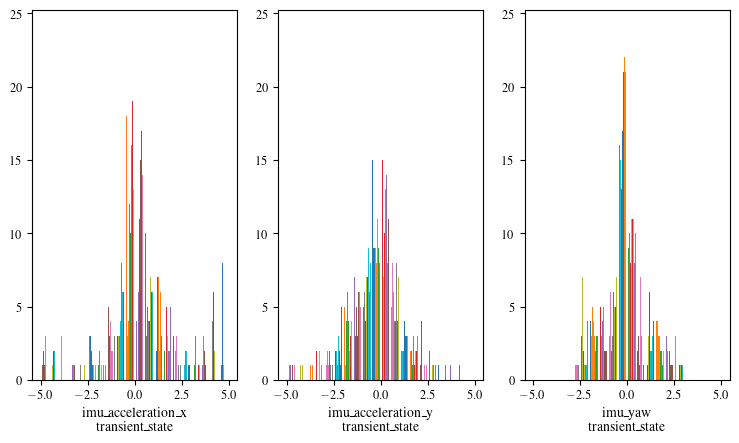

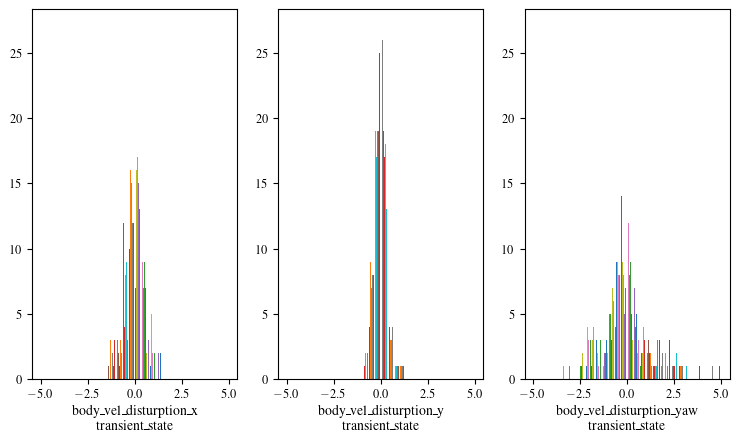

In [30]:
path_slip_dataset = pathlib.Path(path_to_dataset)
path_to_results = path_slip_dataset.parent.parent /"results"

if path_to_results.is_dir() == False:
    path_to_results.mkdir()

plot_all_histogramme(df, df_diamond,path_to_results)


In [31]:
from graph_module import *
path_to_df_slip = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/all_terrain_slip_dataset.pkl"
path_to_df_steady = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/all_terrain_steady_state_dataset.pkl"
producer = GraphicProductionDrive(path_to_df_slip,path_to_df_steady)
producer.produce_slip_histogramme_by_roboticist_for_a_specific_linear_sampling_speed(robiticis_specific=False)



test
test2
Note that the yaw angle in the the smooth version is the IMU
Note that the yaw angle in the the smooth version is the IMU
Note that the yaw angle in the the smooth version is the IMU


In [32]:
def box_plot(df, ax, column_of_interest):

        text = "step_frame_vx_time_constants_to_show"
        
        list_terrain = list(df["terrain"].unique())
        size = len(list_terrain)

        print(df.groupby("terrain")[text].describe())
        # 1. Find all the sub dataframe and compute median 

        # 2. Reorder them by median  
        
        # 3. Boxplot them by order of median 

        # 4. 